# Google colab commands

In [1]:
# !git clone https://github.com/Francesco9932/financial-sentiment-analysis

In [2]:
# %cd financial-sentiment-analysis/

In [3]:
# !unzip glove.6B.200d.txt.zip

# Import

In [4]:
import pandas as pd
import numpy as np

# pre-processing
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import *
from nltk.corpus import stopwords
import re
import nltk 
nltk.download("stopwords")

from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/francesco/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-23 19:23:38.217970: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 19:23:38.259345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the 

# Data preprocessing

In [5]:
df = pd.read_csv('all-data.csv', encoding="latin-1",
                 names=['sentiment', 'headline'])
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


<Axes: xlabel='sentiment'>

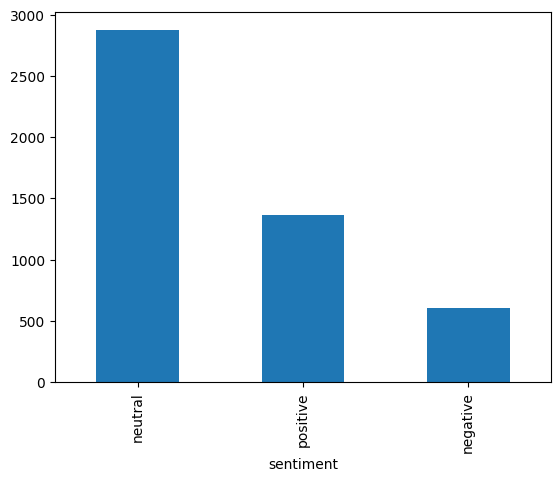

In [6]:
df['sentiment'].value_counts().plot(kind='bar')

In [7]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (4846, 2)
after drop duplicates shape:  (4840, 2)
after drop null shape:  (4840, 2)


In [8]:
df['headline'][1]

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [9]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]

    ## apply stemming
    # words = [PorterStemmer().stem(w) for w in words]
    ## return list

    return  ' '.join(map(str, words))

#print("\nOriginal headline ->", df['headline'][0])

#df['headline'] = df['headline'].apply(headline_to_words)

#print("\nProcessed headline ->", df['headline'][0])

# not used nltk preprocessing

In [10]:
sentences = df['headline'].to_list()

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])

# Tokenizer for other models

In [11]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
print("Vocab length:", len(word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

Vocab length: 10123
Maximum sequence length: 71


In [12]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, df['sentiment'], train_size=0.7, shuffle=True, random_state=1)

In [13]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

Train Set -> (3388, 71) (3388,)
Test Set -> (1452, 71) (1452,)


# Global Vectors for Word Representation (GloVe)

In [14]:
vocab_size = 10123
embedding_size = 200

embeddings_index = {}

with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [15]:
print(embeddings_matrix.shape)

(10124, 200)


# CNN1d Model

In [16]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1],
                              weights=[embeddings_matrix])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)  
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 71, 200)      2024800     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 70, 200)      80200       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 69, 200)      120200      ['embedding[0][0]']              
                                                                                              

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.6150
Epoch 1: val_accuracy improved from -inf to 0.66962, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 5s 47ms/step - loss: 0.8990 - accuracy: 0.6150 - val_loss: 0.7562 - val_accuracy: 0.6696
Epoch 2/100
95/96 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7819
Epoch 2: val_accuracy improved from 0.66962 to 0.73746, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 4s 47ms/step - loss: 0.5292 - accuracy: 0.7822 - val_loss: 0.6001 - val_accuracy: 0.7375
Epoch 3/100
95/96 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9109
Epoch 3: val_accuracy improved from 0.73746 to 0.76991, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 4s 47ms/step - loss: 0.2587 - accuracy: 0.9108 - val_loss: 0.5691 - val_accuracy: 0.7699
Epoch 4/100
9

In [18]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 0.58487
Test accuracy: 78.92562%


# LSTM Model

In [19]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


2023-04-23 19:24:28.711543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 19:24:28.712665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 19:24:28.713405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100


2023-04-23 19:24:28.902359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 19:24:28.904064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 19:24:28.905233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

95/96 [============================>.] - ETA: 0s - loss: 0.8157 - accuracy: 0.6454

2023-04-23 19:24:37.543487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 19:24:37.544843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 19:24:37.545736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.67552, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 9s 83ms/step - loss: 0.8158 - accuracy: 0.6451 - val_loss: 0.7150 - val_accuracy: 0.6755
Epoch 2/100
95/96 [============================>.] - ETA: 0s - loss: 0.4211 - accuracy: 0.8352
Epoch 2: val_accuracy improved from 0.67552 to 0.71386, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 8s 80ms/step - loss: 0.4204 - accuracy: 0.8354 - val_loss: 0.7400 - val_accuracy: 0.7139
Epoch 3/100
95/96 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9579
Epoch 3: val_accuracy did not improve from 0.71386
96/96 [==============================] - 8s 80ms/step - loss: 0.1280 - accuracy: 0.9580 - val_loss: 1.0367 - val_accuracy: 0.7109
Epoch 4/100
95/96 [============================>.] - ETA: 0s - loss: 0.0585 - accuracy: 0.9842
Epoch 4: val_accuracy improved from 0.71386 to 0.72271, saving model

In [21]:
saved_model = load_model('./best_model/best_model_lstm.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

2023-04-23 19:25:17.397850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 19:25:17.399053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 19:25:17.400329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Test Losss: 1.43991
Test accuracy: 74.31129%


# BERT Finetune (finBERT)

In [22]:
tokenizer = BertTokenir = BertTokenizer.from_pretrained('ProsusAI/finbert')
bert = TFBertModel.from_pretrained('ProsusAI/finbert')

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
def calculate_max_sentence_len(sentences):
    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

In [24]:
train_sentences, test_sentences, labels_train, labels_test = train_test_split(
    sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=1)

max_len = min(calculate_max_sentence_len(train_sentences),
              calculate_max_sentence_len(test_sentences))

print('Max sentence length: ', max_len)

X_train = tokenizer(
    text=train_sentences,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=test_sentences,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

print("\nTrain split shape: ", X_train['input_ids'].shape) # the same for attention mask
print("\nTest split shape: ", X_test['input_ids'].shape)

Max sentence length:  120

Train split shape:  (3388, 120)

Test split shape:  (1452, 120)


In [25]:
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids, attention_mask=input_mask)[0]  # 0 = last hidden state, 1 = poller_output

out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(32, activation='relu')(out)

y = tf.keras.layers.Dense(3, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)


model.layers[2].trainable = False 
# check https://stackoverflow.com/questions/60463829/training-tfbertforsequenceclassification-with-custom-x-and-y-data


optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    #decay=0.01,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 120,                                         

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./best_model/finetuned_finBERT.h5',
                     monitor='val_balanced_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/home/francesco/.local/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - ETA: 0s - loss: 0.8072 - balanced_accuracy: 0.6428
Epoch 1: val_balanced_accuracy improved from -inf to 0.78466, saving model to ./best_model/finetuned_finBERT.h5
96/96 [==============================] - 364s 4s/step - loss: 0.8072 - balanced_accuracy: 0.6428 - val_loss: 0.5791 - val_balanced_accuracy: 0.7847
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.5312 - balanced_accuracy: 0.7927
Epoch 2: val_balanced_accuracy improved from 0.78466 to 0.83776, saving model to ./best_model/finetuned_finBERT.h5
96/96 [==============================] - 349s 4s/step - loss: 0.5312 - balanced_accuracy: 0.7927 - val_loss: 0.4272 - val_balanced_accuracy: 0.8378
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.4433 - balanced_accuracy: 0.8268
Epoch 3: val_balanced_accuracy improved from 0.83776 to 0.86431, saving model to ./best_model/finetuned_finBERT.h5
96/96 [==============================] - 352s 4s/step - loss: 0.

In [27]:
saved_model = load_model('./best_model/finetuned_finBERT.h5', custom_objects={"TFBertModel": TFBertModel})

# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted))

46/46 [==============================] - 137s 3s/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       171
           1       0.88      0.94      0.91       862
           2       0.90      0.78      0.83       419

    accuracy                           0.88      1452
   macro avg       0.88      0.86      0.87      1452
weighted avg       0.88      0.88      0.88      1452

